In [1]:
#attach google drive
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [1]:
#import packages
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import precision_recall_curve, roc_curve, accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
import pickle
import os
import numpy as np
import cv2
%matplotlib inline



In [4]:
import os
import cv2
import numpy as np

# Define labels and image size
labels = ['PNEUMONIA', 'NORMAL']
img_size = 60

# Function to load and prepare the training data
def get_training_data(data_dir):
    images = []  # For storing the image data
    label_list = []  # For storing the class labels

    for label in labels:
        path = os.path.join(data_dir, label)  # Get the path for each label
        class_num = labels.index(label)  # Get the class label index

        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)  # Read image in grayscale
                resized_arr = cv2.resize(img_arr, (img_size, img_size))  # Resize image to img_size x img_size
                images.append(resized_arr)  # Append image data to images list
                label_list.append(class_num)  # Append class number to label list
            except Exception as e:
                print(f"Error loading image {img}: {e}")

    # Convert lists to numpy arrays
    images = np.array(images)
    label_list = np.array(label_list)

    return images, label_list

# Get training, testing, and validation datasets
train_images, train_labels = get_training_data('Pnumonia/train')
test_images, test_labels = get_training_data('Pnumonia/test')
val_images, val_labels = get_training_data('Pnumonia/val')

print("Training data shape:", train_images.shape, train_labels.shape)
print("Testing data shape:", test_images.shape, test_labels.shape)
print("Validation data shape:", val_images.shape, val_labels.shape)


Error loading image .ipynb_checkpoints: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

Training data shape: (4100, 60, 60) (4100,)
Testing data shape: (1056, 60, 60) (1056,)
Validation data shape: (700, 60, 60) (700,)


PNEUMONIA: 3000
NORMAL: 1100
PNEUMONIAA - NORMAL: 1900
PNEUMONIA


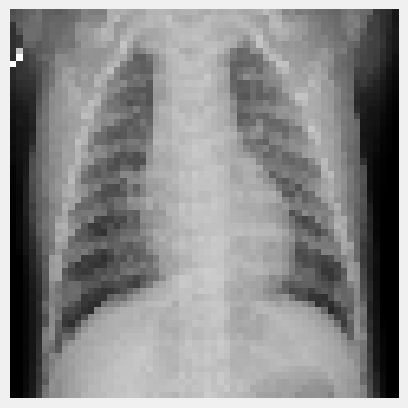

In [5]:
#two-classes
PNEUMONIA = 0
NORMAL = 0

# Loop through the labels and count the occurrences
for j in train_labels:  # j is the label (either 0 or 1)
    if j == 0:
        PNEUMONIA += 1
    else:
        NORMAL += 1

print('PNEUMONIA:', PNEUMONIA)
print('NORMAL:', NORMAL)
print('PNEUMONIAA - NORMAL:', PNEUMONIA - NORMAL)

# Display the second image in the dataset with its label
plt.imshow(train_images[1], cmap='gray')
plt.axis('off')
print(labels[train_labels[1]])

In [6]:
# Append images with labels
X = []
y = []

# Loop over training data (train_images and train_labels)
for feature, label in zip(train_images, train_labels):
    X.append(feature)
    y.append(label)

# Loop over testing data (test_images and test_labels)
for feature, label in zip(test_images, test_labels):
    X.append(feature)
    y.append(label)

# Loop over validation data (val_images and val_labels)
for feature, label in zip(val_images, val_labels):
    X.append(feature)
    y.append(label)

# Resize data for deep learning (reshaping images for model input)
X = np.array(X).reshape(-1, img_size, img_size, 1)  # Assuming grayscale images
y = np.array(y)

# Split the data into train/test/validation sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=32)

print(f"Training set shape: {X_train.shape}, {y_train.shape}")
print(f"Test set shape: {X_test.shape}, {y_test.shape}")
print(f"Validation set shape: {X_val.shape}, {y_val.shape}")


Training set shape: (3747, 60, 60, 1), (3747,)
Test set shape: (1172, 60, 60, 1), (1172,)
Validation set shape: (937, 60, 60, 1), (937,)


In [7]:
#normalize images according to color of images
X_train = X_train / 255
X_test = X_test / 255
X_val = X_val / 255



In [20]:
# Data Augmentation (excluding vertical flips)
datagen = ImageDataGenerator(
    rotation_range=30,       # Reduced rotation range to prevent unrealistic transformations
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(X_train)


In [34]:
#Convolutional-Model
model = Sequential()

model.add(Conv2D(256, (7,7), input_shape=X_train.shape[1:], padding='same'))
model.add(Activation('tanh'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(BatchNormalization(axis=1))

model.add(Conv2D(64, (5,5), padding='same'))
model.add(Activation('tanh'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(BatchNormalization(axis=1))

model.add(Conv2D(16, (3, 3), padding='same'))
model.add(Activation('tanh'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(BatchNormalization(axis=1))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

model.add(Dropout(0.5))
model.add(Dense(64))
model.add(Activation('tanh'))

model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

early_stop = EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True)
adam = Adam(learning_rate=0.0001)
model.compile(loss='binary_crossentropy',optimizer=adam,metrics=['acc'])

model.summary()



Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)                    │ (None, 60, 60, 256)         │          12,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_13 (Activation)           │ (None, 60, 60, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 30, 30, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 30, 30, 256)         │             120 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 30, 30, 64)          │         409,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_14 (Activation)           │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 15, 15, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 15, 15, 64)          │              60 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 15, 15, 16)          │           9,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_15 (Activation)           │ (None, 15, 15, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 8, 8, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 8, 8, 16)            │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │          65,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_16 (Activation)           │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              65 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_17 (Activation)           │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 497,573 (1.90 MB)

 Trainable params: 497,467 (1.90 MB)

 Non-trainable params: 106 (424.00 B)

In [35]:
#epochs-history
history = model.fit(datagen.flow(X_train, y_train, batch_size=10), callbacks=[early_stop], validation_data=(X_val, y_val), epochs=30)


Epoch 1/30


C:\Users\zbadi\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


375/375 ━━━━━━━━━━━━━━━━━━━━ 82s 204ms/step - acc: 0.6581 - loss: 0.7425 - val_acc: 0.7364 - val_loss: 0.5733
Epoch 2/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 78s 209ms/step - acc: 0.6859 - loss: 0.6728 - val_acc: 0.7118 - val_loss: 0.5531
Epoch 3/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 82s 219ms/step - acc: 0.6751 - loss: 0.6814 - val_acc: 0.7343 - val_loss: 0.6219
Epoch 4/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 83s 220ms/step - acc: 0.6935 - loss: 0.6540 - val_acc: 0.7044 - val_loss: 0.5561
Epoch 5/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 83s 222ms/step - acc: 0.6779 - loss: 0.6654 - val_acc: 0.7289 - val_loss: 0.5129
Epoch 6/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 89s 238ms/step - acc: 0.7089 - loss: 0.6152 - val_acc: 0.6275 - val_loss: 0.6970
Epoch 7/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 89s 238ms/step - acc: 0.7430 - loss: 0.5613 - val_acc: 0.7844 - val_loss: 0.4584
Epoch 8/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 83s 221ms/step - acc: 0.7764 - loss: 0.4836 - val_acc: 0.8506 - val_loss: 0.2928
Epoch 9/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 83s

In [36]:
model.evaluate(X_test, y_test)



37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 171ms/step - acc: 0.8612 - loss: 0.3026


[0.3000330328941345, 0.8626279830932617]

In [38]:
pred = model.predict(X_train)

118/118 ━━━━━━━━━━━━━━━━━━━━ 20s 170ms/step


In [ ]:
# Evaluate the Model on Test Set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test Loss: {test_loss:.4f}')

# Plot Training & Validation Accuracy and Loss
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['acc'], label='Train Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [39]:
precisions, recalls, thresholds = precision_recall_curve(y_train, pred)
fpr, tpr, thresholds2 = roc_curve(y_train, pred)


In [40]:
predictions = model.predict(X_test)

37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 166ms/step


In [41]:
binary_predictions = []
threshold = thresholds[np.argmax(precisions >= 0.80)]
for i in predictions:
    if i >= threshold:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0)








print('Accuracy on testing set:', accuracy_score(binary_predictions, y_test))
print('Precision on testing set:', precision_score(binary_predictions, y_test))
print('Recall on testing set:', recall_score(binary_predictions, y_test))


Accuracy on testing set: 0.8600682593856656
Precision on testing set: 0.703125
Recall on testing set: 0.7653061224489796


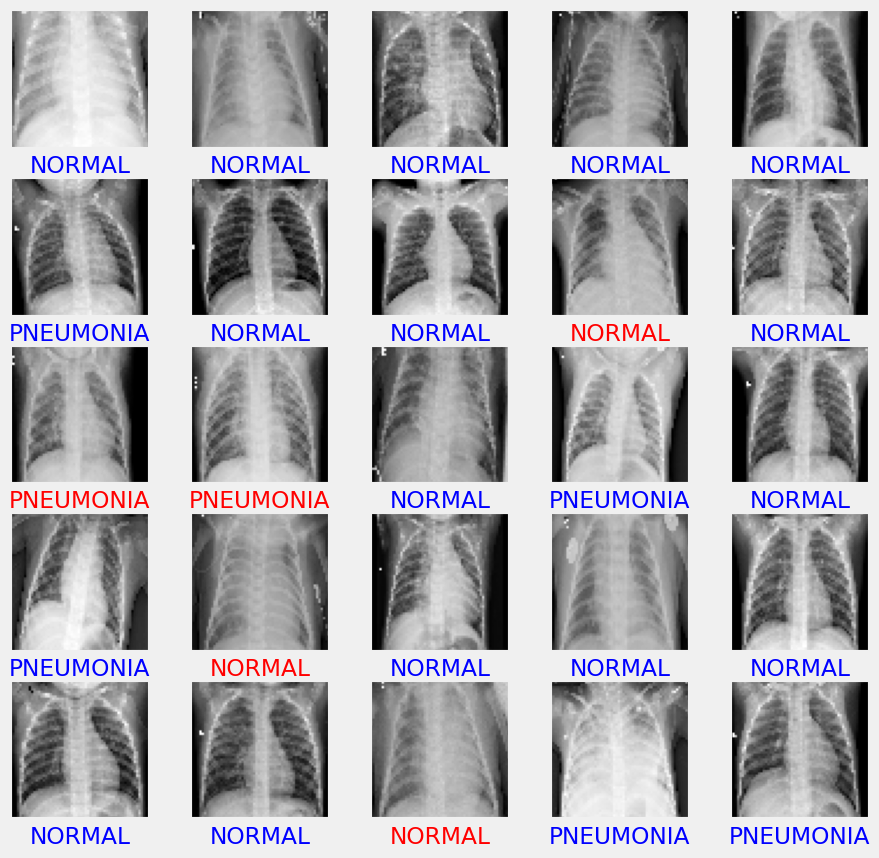

In [42]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train.reshape(-1, img_size, img_size)[i], cmap='gray')
    if(binary_predictions[i]==y_test[i]):
        plt.xlabel(labels[binary_predictions[i]], color='blue')
    else:
        plt.xlabel(labels[binary_predictions[i]], color='red')
plt.show()


In [43]:
#model.save('TB_Detection.h5')
model.save('my_model.keras')

In [44]:
import tensorflow as tf
import numpy as np
import cv2
from tensorflow.keras.models import load_model

# Load the trained model
#model = load_model('TB_Detection.h5')
model = load_model('my_model.keras')

# Image preprocessing function
def preprocess_image(img_path, img_size):
    # Load the image in grayscale
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    # Resize the image to the required input size
    img = cv2.resize(img, (img_size, img_size))

    # Normalize the image (if required by your model) and reshape to match the input shape
    img = img / 255.0  # Scale pixel values to [0, 1]
    img = img.reshape(-1, img_size, img_size, 1)  # Add batch dimension and channel dimension for grayscale

    return img

# Set the image size (should be same as what you used for training)
img_size = 60  # Change this if your model expects a different input size

# Path to the image you want to test
img_path = 'Screenshot 2024-10-11 123223.png'  # Replace with your test image path

# Preprocess the image
preprocessed_img = preprocess_image(img_path, img_size)

# Make prediction
prediction = model.predict(preprocessed_img)

# Since it's a binary classification, get the class index (0 or 1)
predicted_class = np.argmax(prediction, axis=1)[0]

# Labels (assuming 0 is 'Normal' and 1 is 'Tuberculosis')
labels = ['NORMAL', 'PNEUMONIA']

# Print the result
print(f"Predicted class: {labels[predicted_class]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
Predicted class: NORMAL
